### Credium challenge

In [1]:
## import libaries:
import time
from IPython.display import display
import os, sys, subprocess, math
import pandas as pd
import pdal
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import pyproj
import scipy.stats
from shapely.geometry import LineString
import rasterio
import fileinput
import json
import itertools
from pdal_pipelines import *
from geo_functions import *
#import plyfile
#import open3d as o3d
#from vtkplotter import load
#from cjio import cityjson #not needed actually

In [2]:
## define paths:
dir_las = 'F:/CREDIUM/LiDAR_files' ## input las files
csv_alkis = 'F:/CREDIUM/alkis_export.csv' ## input alkis data
plydir = 'F:/CREDIUM/temp' ## folder for temp files --> needs to be an absolute path (will be passed to subprocess call).
polyoutdir = 'F:/CREDIUM/fitted' ## folder for polyfit outputs --> needs to be an absolute path (will be passed to subprocess call).
jsondir = 'F:/CREDIUM/cityjson_files' ## folder for CityJSON output files

## path to polyfit.exe, compiled from C++ sources:
polyfit_exe = 'F:/CREDIUM/polyfit_example_without_input_planes.exe'

In [3]:
## read cadastral data:
alkisdf = pd.read_csv(csv_alkis)
## create two versions of geodataframes, using the building geometry and the outer geometry given in the data:
alkisgdf_building = gp.GeoDataFrame(alkisdf, geometry=gp.GeoSeries.from_wkt(alkisdf.raw_poly))
alkisgdf_parcel = gp.GeoDataFrame(alkisdf.copy(), geometry=gp.GeoSeries.from_wkt(alkisdf.full_poly)) # these are bounding boxes of the lidar data, not parcels.
epsg_alkis = 25832  # we assume it is in UTM zone 32
print(len(alkisdf))

2219


processing building ## read cadastral data:
alkisdf = pd.read_csv(csv_alkis)
## create two versions of geodataframes, using the building geometry and the outer geometry given in the data:
alkisgdf_building = gp.GeoDataFrame(alkisdf, geometry=gp.GeoSeries.from_wkt(alkisdf.raw_poly))
alkisgdf_parcel = gp.GeoDataFrame(alkisdf.copy(), geometry=gp.GeoSeries.from_wkt(alkisdf.full_poly)) # these are bounding boxes of the lidar data, not parcels.
epsg_alkis = 25832  # we assume it is in UTM zone 32
print(len(alkisdf))...


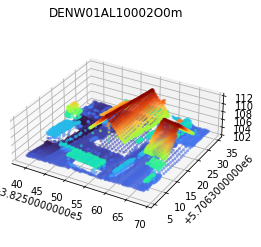

In [4]:
## pick an example building and process lidar data:
row = alkisgdf_building.iloc[0]

## retrieve LAS file:
print('processing building %s...' % _i)    
lasfile = dir_las+'/%s.las' % row.gmlid
if not os.path.exists(lasfile):
    sys.exit(0)

## read LAS file:
r = pdal.Pipeline(pipeline_read.replace('LASFILE', lasfile))
r.execute()

## check if CRS in LAS and CRS in Alkis is identical:
las_crs = pyproj.crs.CRS(
    r.metadata['metadata']['readers.las']['comp_spatialreference'])
las_crs_hz = las_crs.sub_crs_list[0]
las_crs_hz_epsg = las_crs_hz.to_epsg()
if not epsg_alkis == las_crs_hz_epsg:
    print('CRS do not match')
        
## get las data into numpy arrays:
las_content = r.arrays
xs_all = las_content[0]['X']
ys_all = las_content[0]['Y']
zs_all = las_content[0]['Z']

## get point attributes and rank transform them for visusalization:
gpstime = scipy.stats.rankdata(las_content[0]['GpsTime'])
scanangle = scipy.stats.rankdata(las_content[0]['ScanAngleRank'])
intensity = scipy.stats.rankdata(las_content[0]['Intensity'])
classification = las_content[0]['Classification']
numreturns = scipy.stats.rankdata(las_content[0]['NumberOfReturns'])

## plot raw las data:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs_all, ys_all, zs_all, s=4,
           c=zs_all, cmap='turbo', alpha=0.5)
ax.set_box_aspect((np.ptp(xs_all), np.ptp(ys_all), np.ptp(zs_all)))
plt.title(row.gmlid)
plt.show() 

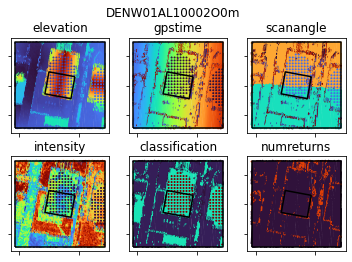

In [5]:
## plot point attributes:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
colorvars = np.array([[zs_all, gpstime, scanangle], [
                     intensity, classification, numreturns]])
varnames = np.array([['elevation', 'gpstime', 'scanangle'], [
                    'intensity', 'classification', 'numreturns']])
for i in np.arange(colorvars.shape[0]):
    for j in np.arange(colorvars.shape[1]):
        ax = axs[i, j]
        ax.scatter(xs_all, ys_all, s=1,
                   c=colorvars[i, j], cmap='turbo', alpha=1.0)
        alkisgdf_building[alkisgdf_building.gmlid == row.gmlid].boundary.plot(
            ax=ax, edgecolor='black', facecolor=None)
        alkisgdf_parcel[alkisgdf_parcel.gmlid == row.gmlid].boundary.plot(
            ax=ax, edgecolor='black', facecolor=None)
        ax.set_title(varnames[i, j])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
plt.suptitle(row.gmlid)
plt.show()

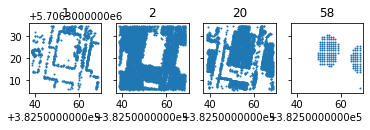

In [6]:
## plot lidar points for different classes:
uq_classes = np.unique(classification)
num_classes = len(uq_classes)
fig, axs = plt.subplots(1, num_classes, sharex=True, sharey=True)
for i, pointclass in enumerate(uq_classes):
    idxs = np.where(classification == pointclass)[0]
    ax = axs[i]
    ax.scatter(xs_all[idxs], ys_all[idxs], s=1)
    ax.set_title(pointclass)
    ax.set_aspect('equal')
    # ax.set_xlim(min(xs_all),max(xs_all))
    # ax.set_ylim(min(ys_all),max(ys_all))
plt.show()

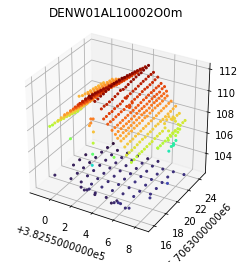

In [7]:
## crop point cloud to building footprint from the cadastral data:
pipeline_read_crop = """{
  "pipeline": [
    {
        "type": "readers.las",
        "filename": "LASFILE"
    },
   {
       "type":"filters.crop",
       "polygon":"POLYGON_WKT"
   }    
  ]
}"""
#curr_plyfile = plydir+'/%s.ply' % row.gmlid
r = pdal.Pipeline(pipeline_read_crop
                  .replace('LASFILE', lasfile)
                  # row.geometry.buffer(2).wkt
                  .replace('POLYGON_WKT', row.geometry.wkt))#.replace('PLYFILE', curr_plyfile)
r.execute()

## read the output of the pdal pipeline into numpy arrays:
las_content = r.arrays
xs_clip = las_content[0]['X']
ys_clip = las_content[0]['Y']
zs_clip = las_content[0]['Z']
num_orig_pts=len(xs_clip)

## visualize the cropped point cloud:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs_clip, ys_clip, zs_clip, s=4,
           c=zs_clip, cmap='turbo', alpha=1.0)
ax.set_box_aspect((np.ptp(xs_clip), np.ptp(ys_clip), np.ptp(zs_clip)))
plt.title(row.gmlid)
plt.show()


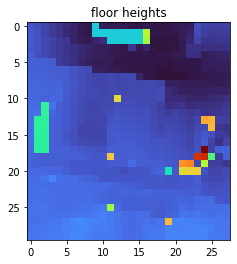

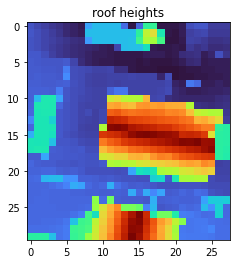

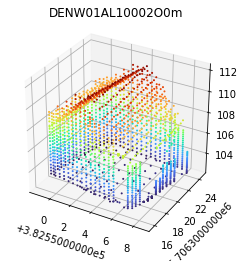

We had 563 points. Now we have 1823 points


In [8]:
## densify the point cloud: pt 1 - walls:
## 1) add vertices to the building footprint line feature.
## 2) determine the approximate ground and roof height at each vertex.
## 3) add wall points by extruding vertex 2d locations between the ground and roof height

## get building outline:
bldg_outline = alkisgdf_building[alkisgdf_building.gmlid == row.gmlid].geometry.values[0]

## add additional vertices every set_pt_every_n_meter, and add numheights wall point per vertex
set_pt_every_n_meter = 0.5
numheights = 20
## get the approximate floor / roof heights at each location from grids of cellsize:
cellsize = 1

boundary_dense = densify_geometry(
    bldg_outline.boundary, set_pt_every_n_meter, epsg_alkis)
vertex_xs, vertex_ys = boundary_dense.values[0].coords.xy
vertex_xys = list(zip(vertex_xs, vertex_ys))

## what is the approximate floor and roof height at each vertex?
## --> gridding the point cloud into 0.5m bins, extracting min (floor) and median (roof, outlier-insensitive)

binnedstats = scipy.stats.binned_statistic_2d(x=xs_all, y=ys_all, values=zs_all,
                                              statistic='min',
                                              bins=(np.arange(xs_all.min(), xs_all.max(), cellsize), np.arange(ys_all.min(), ys_all.max(), cellsize)))


## extract the raster value at each vertex:
voxel_min = binnedstats.statistic
x_edges = binnedstats.x_edge
y_edges = binnedstats.y_edge
vertex_zs_min = [voxel_min[np.digitize(xy[0], x_edges), np.digitize(xy[1], y_edges)] for xy in vertex_xys]

## do the same for the roof points:
binnedstats = scipy.stats.binned_statistic_2d(x=xs_all, y=ys_all, values=zs_all,
                                              statistic='median',
                                              bins=(np.arange(xs_all.min(), xs_all.max(), cellsize), np.arange(ys_all.min(), ys_all.max(), cellsize)))
voxel_max = binnedstats.statistic
x_edges = binnedstats.x_edge
y_edges = binnedstats.y_edge
vertex_zs_max = [voxel_max[np.digitize(xy[0], x_edges), np.digitize(xy[1], y_edges)] for xy in vertex_xys]

## regularly spaced points along Z dimension (i.e., the walls)
addtl_x = []
addtl_y = []
addtl_z = []
for i, vertex_xy in enumerate(vertex_xys[:-1]):
    heights = np.linspace(vertex_zs_min[i], vertex_zs_max[i], numheights)
    for height in heights:
        addtl_x.append(vertex_xy[0])
        addtl_y.append(vertex_xy[1])
        addtl_z.append(height)

## merge new points with existing points:
xs_clip = np.round(np.append(xs_clip, addtl_x), 1)
ys_clip = np.round(np.append(ys_clip, addtl_y), 1)
zs_clip = np.round(np.append(zs_clip, addtl_z), 1)

## plot it:
fig, ax = plt.subplots()
ax.imshow(voxel_min, cmap='turbo')
plt.title('floor heights')
plt.show()
fig, ax = plt.subplots()
ax.imshow(voxel_max, cmap='turbo')
plt.title('roof heights')
plt.show()
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs_clip, ys_clip, zs_clip, s=1, c=zs_clip, cmap='turbo', alpha=1.0)
ax.set_box_aspect((np.ptp(xs_clip), np.ptp(ys_clip), np.ptp(zs_clip)))
plt.title(row.gmlid)
plt.show()

print("We had %s points. Now we have %s points" %(num_orig_pts,len(xs_clip)))

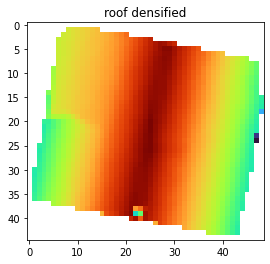

In [9]:
## densify the point cloud: pt 2 - roof:
## --> densify the roof by using triangulation and raster sampling (10cm resolution)
lasdf = pd.DataFrame(las_content[0])
roofdf = lasdf[lasdf.Classification == 20] ## the roof points

if len(roofdf)==0:
    sys.exit(0)
    
## use pdal to sample raster points and write to raster file:
pipeline_densify = """{
  "pipeline": [
    {
        "type": "filters.delaunay"
    },
    {
        "type": "filters.faceraster",
        "resolution": 0.2
    },
    {
        "type": "writers.raster",
        "filename":"RASTERFILE"
    }
  ]
}"""
struct_arr_roof = [roofdf.to_records(index=False)] # output as structured array, requirement for pdal.
curr_rasterfile_roof = plydir+'/%s_roof.tif' % row.gmlid
densify_pipeline = pdal.Pipeline(pipeline_densify.replace(
    'RASTERFILE', curr_rasterfile_roof), struct_arr_roof)
densify_pipeline.execute()

# read raster as points:
pipeline_read_roof = """{
  "pipeline": [
    {
        "type": "readers.gdal",
        "filename": "RASTERFILE"
    }   
  ]
}"""
read_dense_roof_pipeline = pdal.Pipeline(
    pipeline_read_roof.replace('RASTERFILE', curr_rasterfile_roof))
read_dense_roof_pipeline.execute()

# vis
dense_roof_arr = rasterio.open(curr_rasterfile_roof).read(1)
dense_roof_arr[dense_roof_arr == -9999] = np.nan
fig, ax = plt.subplots()
ax.imshow(dense_roof_arr, cmap='turbo')
plt.title('roof densified')
plt.show()

# add raster as points
roof_content = read_dense_roof_pipeline.arrays
xs_roof = roof_content[0]['X']
ys_roof = roof_content[0]['Y']
zs_roof = roof_content[0]['band_1']
roofdf = pd.DataFrame({'X': xs_roof, 'Y': ys_roof, 'Z': zs_roof})
roofdf = roofdf[roofdf.Z > -9999]
xs_roof = roofdf.X.values.copy()
ys_roof = roofdf.Y.values.copy()
zs_roof = roofdf.Z.values.copy()

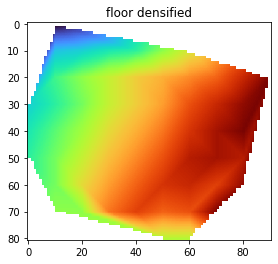

In [10]:
## densify the point cloud: pt 3 - floor:
## --> densify the roof by using triangulation and raster sampling
lasdf = pd.DataFrame(las_content[0])
floordf = lasdf[lasdf.Classification == 58] ## the floor points

if len(floordf) == 0:
    sys.exit(0)

pipeline_densify = """{
  "pipeline": [
    {
        "type": "filters.delaunay"
    },
    {
        "type": "filters.faceraster",
        "resolution": 0.1
    },
    {
        "type": "writers.raster",
        "filename":"RASTERFILE"
    }
  ]
}"""
struct_arr_floor = [floordf.to_records(index=False)] # output as structured array, requirement for pdal.
curr_rasterfile_floor = plydir+'/%s_floor.tif' % row.gmlid
densify_pipeline = pdal.Pipeline(pipeline_densify.replace(
    'RASTERFILE', curr_rasterfile_floor), struct_arr_floor)
densify_pipeline.execute()

# read raster as points:
read_dense_floor_pipeline = pdal.Pipeline(
    pipeline_read_roof.replace('RASTERFILE', curr_rasterfile_floor))
read_dense_floor_pipeline.execute()

# visualize raster:
dense_floor_arr = rasterio.open(curr_rasterfile_floor).read(1)
dense_floor_arr[dense_floor_arr == -9999] = np.nan
fig, ax = plt.subplots()
ax.imshow(dense_floor_arr, cmap='turbo')
plt.title('floor densified')
plt.show()

# add raster points:
floor_content = read_dense_floor_pipeline.arrays
xs_floor = floor_content[0]['X']
ys_floor = floor_content[0]['Y']
zs_floor = floor_content[0]['band_1']
floordf = pd.DataFrame({'X': xs_floor, 'Y': ys_floor, 'Z': zs_floor})
floordf = floordf[floordf.Z > -9999]
xs_floor = floordf.X.values.copy()
ys_floor = floordf.Y.values.copy()
zs_floor = floordf.Z.values.copy()

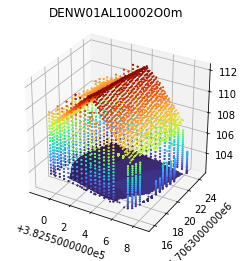

In [11]:
## merge original lidar points with artificial wall points and densified roof and floor points, round to decimeters
xs_clip = np.round(np.append(np.append(np.append(xs_clip, addtl_x), xs_roof), xs_floor), 1)
ys_clip = np.round(np.append(np.append(np.append(ys_clip, addtl_y), ys_roof), ys_floor), 1)
zs_clip = np.round(np.append(np.append(np.append(zs_clip, addtl_z), zs_roof), zs_floor), 1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs_clip, ys_clip, zs_clip, s=1, c=zs_clip, cmap='turbo', alpha=1.0)
ax.set_box_aspect((np.ptp(xs_clip), np.ptp(ys_clip), np.ptp(zs_clip)))
plt.title(row.gmlid)
plt.show()

In [12]:
## preprocess data for input into polyfit:

df = pd.DataFrame({'X': xs_clip, 'Y': ys_clip, 'Z': zs_clip}, dtype=float)
df = df[df.Z > -9999]  # remove no data from roof densification raster

## we subtract constant on Y values, as they get truncated in OFF and PLY format when outputting through CGAL
y_offset = 5700000
df.Y = df.Y-y_offset

## write to structured array for further processing in PDAL:
struct_arr = [df.to_records(index=False)]

## caclulate unoriented normals, a requirement for RANSAC plane fitting, write to PLY file:
pipeline_calc_normals_write_array_ply = """{
  "pipeline": [    
    {
        "type":"filters.normal",
        "knn":8,
        "refine":true
    },
    {
        "type":"writers.ply",
        "sized_types":false,
        "precision":2,
        "faces":true,
        "filename":"PLYFILE"
    }
  ]
}"""
curr_plyfile = plydir+'/%s_mod.ply' % row.gmlid
write_pipeline = pdal.Pipeline(pipeline_calc_normals_write_array_ply.replace(
    'PLYFILE', curr_plyfile), struct_arr)
write_pipeline.execute()

## important. the polyfit exe only detects planes if normal vectors are called nx,ny,nz and NOT normalx,normaly,normalz!
# for now we do this modification in the PLY ascii file:
for line in fileinput.input(curr_plyfile, inplace=1):
    print(line.replace('normalx', 'nx').replace('normaly', 'ny').replace('normalz', 'nz').rstrip())
fileinput.close()

print('created %s' %curr_plyfile)

created F:/CREDIUM/temp/DENW01AL10002O0m_mod.ply


In [13]:
## run polyfit, which will create a watertight 3d object from our pointcloud:

## RANSAC parameters:
probability = 0.8
min_points = 10#40
epsilon = 0.25
cluster_epsilon = 6.25
normal_threshold = 0.01

polyfit_out_surfaces = polyoutdir+'/%s_fitted.off' % row.gmlid
polyfit_out_meshes = plydir+'/%s_meshes.ply' % row.gmlid
polyfit_call = polyfit_exe+' %s %s %s %s %s %s %s %s' % (curr_plyfile,
                                                         polyfit_out_surfaces,
                                                         polyfit_out_meshes,
                                                         probability, min_points, epsilon,
                                                         cluster_epsilon, normal_threshold)
print(polyfit_call)

try:
    response = subprocess.check_output(polyfit_call, shell=True)
    print('success')
except:
    sys.exit(0)
    #failed.append(row.gmlid)
    
print('polyfit output written to file: %s' %polyfit_out_surfaces)

# visualize the polyfit output: throws error due to OpenGL issue!
#pcd = o3d.io.read_triangle_mesh(polyfit_out_surfaces)
#vis = o3d.visualization.Visualizer()
#vis.create_window()
#vis.add_geometry(pcd)
#vis.update_renderer()

F:/CREDIUM/polyfit_example_without_input_planes.exe F:/CREDIUM/temp/DENW01AL10002O0m_mod.ply F:/CREDIUM/fitted/DENW01AL10002O0m_fitted.off F:/CREDIUM/temp/DENW01AL10002O0m_meshes.ply 0.8 10 0.25 6.25 0.01
success
polyfit output written to file: F:/CREDIUM/fitted/DENW01AL10002O0m_fitted.off


### Now load the resulting file in https://3dviewer.net

### RANSAC parameter tuning

In [14]:
## how did I get the parameters that I used? 
## I did a grid search and picked a set of parameters that seem to produce a reasonable amount of surfaces:
## here we only run a random sample of the parameter combination used in the actual gridsearch.

#RANSAC parameters gridsearch: ###########
range_probability = np.arange(0.01, 0.9, 0.4)
range_min_points = np.arange(4, 50, 20)
range_epsilon = np.arange(0.25, 10, 3)
range_cluster_epsilon = np.arange(0.25, 10, 3)
range_normal_threshold = np.arange(0.01, 0.9, 0.4)

a=[]
a.append(list(range_probability))
a.append(list(range_min_points))
a.append(list(range_epsilon))
a.append(list(range_cluster_epsilon))
a.append(list(range_normal_threshold))
all_combis = np.array(list(itertools.product(*a)))
sample_combis = all_combis[np.random.randint(0, high=len(all_combis), size=20)]

counter=0
gridsearch_stats=[]
for sample_combi in sample_combis:
    probability, min_points,epsilon, cluster_epsilon, normal_threshold = sample_combi
    created_planes = False
    counter+=1
    if counter==20:
        break
    try:
        print(counter,'trying', probability, min_points,
              epsilon, cluster_epsilon, normal_threshold)
        polyfit_out_surfaces = plydir+'/%s_test_fitted_%s_%s_%s_%s_%s.off' % (
            row.gmlid, probability, min_points, epsilon, cluster_epsilon, normal_threshold)
        polyfit_out_meshes = plydir+'/%s_test_meshes_%s_%s_%s_%s_%s.ply' % (
            row.gmlid, probability, min_points, epsilon, cluster_epsilon, normal_threshold)
        polyfit_call = polyfit_exe+' %s %s %s %s %s %s %s %s' % (curr_plyfile,
                                                                 polyfit_out_surfaces,
                                                                 polyfit_out_meshes,
                                                                 probability, min_points, epsilon,
                                                                 cluster_epsilon, normal_threshold)
        proc1 = subprocess.check_output(polyfit_call, shell=True) 
        created_planes = True
    except Exception as e:
        print(e)
        gridsearch_stats.append([probability, min_points, epsilon,
        cluster_epsilon, normal_threshold,0, 0]) 

    if created_planes:
        currtime=time.asctime(time.localtime(time.time()))
        print(counter, currtime,'worked', probability, min_points,
              epsilon, cluster_epsilon, normal_threshold)

        # read vertices and faces from resulting OFF file:
        with open(polyfit_out_surfaces) as f:
            lines = f.readlines()
            f.close()
        num_vertices, num_faces, other = [int(x) for x in lines[1].rstrip().split(' ')]
        gridsearch_stats.append([probability, min_points, epsilon,
        cluster_epsilon, normal_threshold,num_vertices, num_faces])                        

                                                

1 trying 0.01 4.0 3.25 9.25 0.41000000000000003
Command 'F:/CREDIUM/polyfit_example_without_input_planes.exe F:/CREDIUM/temp/DENW01AL10002O0m_mod.ply F:/CREDIUM/temp/DENW01AL10002O0m_test_fitted_0.01_4.0_3.25_9.25_0.41000000000000003.off F:/CREDIUM/temp/DENW01AL10002O0m_test_meshes_0.01_4.0_3.25_9.25_0.41000000000000003.ply 0.01 4.0 3.25 9.25 0.41000000000000003' returned non-zero exit status 1.
2 trying 0.41000000000000003 4.0 0.25 6.25 0.41000000000000003
2 Tue Jun 14 14:49:11 2022 worked 0.41000000000000003 4.0 0.25 6.25 0.41000000000000003
3 trying 0.81 44.0 9.25 9.25 0.81
3 Tue Jun 14 14:49:11 2022 worked 0.81 44.0 9.25 9.25 0.81
4 trying 0.01 24.0 9.25 0.25 0.41000000000000003
4 Tue Jun 14 14:49:12 2022 worked 0.01 24.0 9.25 0.25 0.41000000000000003
5 trying 0.01 44.0 9.25 3.25 0.41000000000000003
Command 'F:/CREDIUM/polyfit_example_without_input_planes.exe F:/CREDIUM/temp/DENW01AL10002O0m_mod.ply F:/CREDIUM/temp/DENW01AL10002O0m_test_fitted_0.01_44.0_9.25_3.25_0.4100000000000000

### The following results illustrate the sensitivity of the polyfit method to the RANSAC parameters:

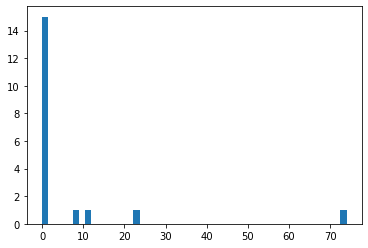

,probability,min_points,epsilon,cluster_epsilon,normal_threshold,num_vertices,num_faces
0,0.01,4.0,3.25,9.25,0.41,0,0
16,0.81,24.0,3.25,3.25,0.41,0,0
14,0.81,4.0,9.25,6.25,0.81,0,0
13,0.81,4.0,3.25,3.25,0.41,0,0
12,0.81,44.0,9.25,3.25,0.81,0,0
17,0.41,4.0,9.25,9.25,0.81,0,0
8,0.41,4.0,6.25,9.25,0.41,0,0
9,0.41,44.0,9.25,0.25,0.81,0,0
6,0.41,4.0,6.25,6.25,0.01,0,0
5,0.01,44.0,3.25,9.25,0.01,0,0


In [15]:
gridsearch_stats=pd.DataFrame(gridsearch_stats,columns=['probability', 'min_points', 'epsilon',
                                                 'cluster_epsilon', 'normal_threshold','num_vertices', 'num_faces'])
fig,ax=plt.subplots()
ax.hist(gridsearch_stats.num_faces,bins=50)
plt.show()

display(gridsearch_stats.sort_values(by='num_faces'))

## convert the agnostic 3d model into a semantic 3d model

In [16]:
### read polyfit output and extract coordinates and faces

polyfit_out_surfaces = polyoutdir+'/%s_fitted.off' % row.gmlid
if not os.path.exists(polyfit_out_surfaces):
    sys.exit(0)

# read vertices and faces from OFF file:
with open(polyfit_out_surfaces) as f:
    lines = f.readlines()
    f.close()        
num_vertices, num_faces, other = [int(x) for x in lines[1].rstrip().split(' ')]

if num_vertices == 0:
    sys.exit(0)    

curr_vertices = [[float(y) for y in x.rstrip().split(' ')] for x in lines[3:3+num_vertices]]
## reconstruct world coordinates:
curr_vertices = [[x[0], x[1]+y_offset, x[2]] for x in curr_vertices]  # add y offset again !

## reduce data volume by transforming the geocoordinates:
## this will be recreated in CityJSON
curr_verticesdf=pd.DataFrame(curr_vertices,columns=['x','y','z'])
shiftx,shifty,shiftz = np.mean(curr_verticesdf[['x','y','z']].values,axis=0)
scalefactor=1000
curr_verticesdf.x = curr_verticesdf.x-shiftx
curr_verticesdf.y = curr_verticesdf.y-shifty
curr_verticesdf.z = curr_verticesdf.z-shiftz
curr_vertices = (scalefactor*curr_verticesdf.values).astype(int).tolist()

curr_faces = [[[int(y) for y in x.split('  ')[-1].rstrip().split(' ')]] for x in lines[3+num_vertices:-1]]

if len(curr_faces) == 0:
    sys.exit(0)   
    
display(curr_vertices)
display(curr_faces)

[[4299, -4398, -3466],
 [-3700, 4361, -3803],
 [-4700, -2858, -3767],
 [5299, 2871, -3505],
 [-700, -3718, 4960],
 [299, 3701, 5392],
 [-4700, -2908, 932],
 [-3700, 4401, 1437],
 [-3700, 4401, 1437],
 [-4700, -2908, 932],
 [-4700, -2908, 932],
 [299, 3701, 5392],
 [-700, -3718, 4960],
 [4299, 2951, 1142],
 [3299, -4408, 676],
 [3299, -4408, 676],
 [299, 3701, 5392],
 [-3700, 4361, -3803],
 [-3700, 4401, 1437],
 [5299, 2871, -3505],
 [4299, 2951, 1142],
 [-700, -3718, 4960],
 [-4700, -2858, -3767],
 [4299, -4398, -3466],
 [5299, 2871, -3505],
 [4299, -4398, -3466],
 [-3700, 4361, -3803],
 [-4700, -2858, -3767],
 [4299, 2951, 1142],
 [3299, -4408, 676]]

[[[0, 3, 1, 2]],
 [[6, 7, 5, 4]],
 [[13, 14, 12, 11]],
 [[24, 28, 16, 8, 26]],
 [[25, 29, 21, 9, 27]],
 [[10, 22, 17, 18]],
 [[15, 23, 19, 20]]]

### account for vertex order (clockwise vs counterclockwise) in the 3d polygons (to be completed)

In [17]:
# check if the vertex order is consistent (counterclockwise?) otherwise 3d viz will fail 
# as the vertex order (and resulting normal vector) define whcih face is indoor and outdoor.

curr_vertices_arr=np.array(curr_vertices)

## centroid of the building in 3d space - assumed to be within the building
global_centroid = np.mean(curr_vertices_arr,axis=0)

### get normal vector and centroids-centroid vector of each face    
normal_vecs=[]
face_glob_centroid_vects=[]
for face in curr_faces:
    facepoints=curr_vertices_arr[face[0],:].tolist()
    curr_centroid = np.mean(facepoints[:3],axis=0) # is on the plane
    face_glob_centroid_vect = global_centroid-curr_centroid # a vector pointing towards the inside of the building
    ## calculate normal vector:
    p0, p1, p2 = facepoints[:3]
    x0, y0, z0 = p0
    x1, y1, z1 = p1
    x2, y2, z2 = p2        
    u = [x1-x0, y1-y0, z1-z0] #first vector
    v = [x0-x2, y0-y2, z0-z2] #sec vector
    u_cross_v=np.cross(u,v)
    normal_vecs.append(u_cross_v)
    face_glob_centroid_vects.append(face_glob_centroid_vect.tolist())
 
vecdf=pd.DataFrame({'nx':np.array(normal_vecs)[0,:],
                       'ny':np.array(normal_vecs)[1,:],
                       'nz':np.array(normal_vecs)[2,:],
                       'ccx':np.array(face_glob_centroid_vects)[0,:],
                       'ccy':np.array(face_glob_centroid_vects)[1,:],
                       'ccz':np.array(face_glob_centroid_vects)[2,:]})

#### TO BE COMPLETED !!!!

In [18]:
# determine the semantics of the faces (floor, wall, roof):

# for each face, calculate average and range of z values:
facestats = []
curr_verticesdf = pd.DataFrame(curr_vertices, columns=['x', 'y', 'z'])
for i, face in enumerate(curr_faces):
    currvert = curr_verticesdf.iloc[face[0]]
    z_avg = currvert.z.mean()
    z_range = currvert.z.max()-currvert.z.min()
    facestats.append([face[0], i, z_avg, z_range])
facestats_df = pd.DataFrame(
    facestats, columns=['face', 'faceid', 'z_avg', 'z_range'])
facestats_df = facestats_df.sort_values(by='z_avg').reset_index()
floor_face_id = facestats_df.iloc[0].faceid

# rule-based semantic assignment based on given rooftype from Alkis data: --> could be done using lidar classification as well!!
if row.dachform == 'Flachdach': # face with highest average z value is roof
    # top 1 face sorted by avg face vertex height is roof
    roof_face_ids = facestats_df.iloc[[-1]].faceid.values
else:# 2 faces with highest average z value is roof
    # Satteldach or similar, we use the top 2.
    roof_face_ids = facestats_df.iloc[[-2, -1]].faceid.values

semantic_surfaces = []
for i, face in enumerate(curr_faces):
    if i in roof_face_ids:
        semantic_surfaces.append({"type": "RoofSurface"})
    elif i == floor_face_id:
        semantic_surfaces.append({"type": "GroundSurface"})
    else:
        semantic_surfaces.append({"type": "WallSurface"})

# write out to cityjson - note that the attributes are dummy values for now, need to be mapped / calculated
feature = {
    row.gmlid: {
        'attributes': {"measuredHeight": 9.0,
                       "roofType": "1030",
                       "storeysAboveGround": 2,
                       "storeysBelowGround": 0,
                       "storeyHeightsAboveGround": [3.0],
                       "storeyHeightsBelowGround": [0.0],
                       "yearOfConstruction": 1944,
                       "yearOfDemolition": 2059,
                       "class": "1150"},
        'type': "Building",
        'geometry': [{"type": "MultiSurface",
                      'boundaries': curr_faces,
                      "semantics": {
                          "values": [int(x) for x in list(np.arange(0, len(curr_faces)))],
                          "surfaces": semantic_surfaces},
                      "lod":2}]}}

display(feature)

{'DENW01AL10002O0m': {'attributes': {'measuredHeight': 9.0,
   'roofType': '1030',
   'storeysAboveGround': 2,
   'storeysBelowGround': 0,
   'storeyHeightsAboveGround': [3.0],
   'storeyHeightsBelowGround': [0.0],
   'yearOfConstruction': 1944,
   'yearOfDemolition': 2059,
   'class': '1150'},
  'type': 'Building',
  'geometry': [{'type': 'MultiSurface',
    'boundaries': [[[0, 3, 1, 2]],
     [[6, 7, 5, 4]],
     [[13, 14, 12, 11]],
     [[24, 28, 16, 8, 26]],
     [[25, 29, 21, 9, 27]],
     [[10, 22, 17, 18]],
     [[15, 23, 19, 20]]],
    'semantics': {'values': [0, 1, 2, 3, 4, 5, 6],
     'surfaces': [{'type': 'GroundSurface'},
      {'type': 'RoofSurface'},
      {'type': 'RoofSurface'},
      {'type': 'WallSurface'},
      {'type': 'WallSurface'},
      {'type': 'WallSurface'},
      {'type': 'WallSurface'}]},
    'lod': 2}]}}

## define a dictionary with some metadata and write to CityJSON file:

In [19]:
## bounding box for visualization:
min_x_total = np.min(xs_clip)-250
max_x_total = np.max(xs_clip)-250
min_y_total = np.min(ys_clip)-5
max_y_total = np.max(ys_clip)+250
min_z_total = np.min(zs_clip)+250
max_z_total = np.max(zs_clip)+5

num_bldgs=1
geo_json_dict = {
    "type": "CityJSON",
    "version": "1.0",
    "metadata": {
        "geographicalExtent": [min_x_total, min_y_total, min_z_total, max_x_total, max_y_total, max_z_total],
        "presentLoDs": {"2.0": num_bldgs}},
    "CityObjects": {},
    "transform": {
        "scale": [scalefactor,scalefactor,scalefactor],
        "translate": [shiftx,shifty,shiftz]
    },
    "vertices": []
}
## add current building to the CityObjects dict:
geo_json_dict["CityObjects"].update(feature)

geo_json_dict["vertices"] = curr_vertices
geo_json_dict["crs"] = {"type": "name", "properties": {
    "name": "EPSG:{}".format(epsg_alkis)}}
jsonfile=jsondir+os.sep+'%s.json' %row.gmlid
geo_json_file = open(jsonfile, 'w+')
geo_json_file.write(json.dumps(geo_json_dict, indent=2))
geo_json_file.close()

display(geo_json_dict)
print('written to %s' %jsonfile)
print('created:'+time.asctime(time.localtime(time.time())))

{'type': 'CityJSON',
 'version': '1.0',
 'metadata': {'geographicalExtent': [382298.7,
   5706310.7,
   352.7,
   382308.7,
   5706574.6,
   116.9],
  'presentLoDs': {'2.0': 1}},
 'CityObjects': {'DENW01AL10002O0m': {'attributes': {'measuredHeight': 9.0,
    'roofType': '1030',
    'storeysAboveGround': 2,
    'storeysBelowGround': 0,
    'storeyHeightsAboveGround': [3.0],
    'storeyHeightsBelowGround': [0.0],
    'yearOfConstruction': 1944,
    'yearOfDemolition': 2059,
    'class': '1150'},
   'type': 'Building',
   'geometry': [{'type': 'MultiSurface',
     'boundaries': [[[0, 3, 1, 2]],
      [[6, 7, 5, 4]],
      [[13, 14, 12, 11]],
      [[24, 28, 16, 8, 26]],
      [[25, 29, 21, 9, 27]],
      [[10, 22, 17, 18]],
      [[15, 23, 19, 20]]],
     'semantics': {'values': [0, 1, 2, 3, 4, 5, 6],
      'surfaces': [{'type': 'GroundSurface'},
       {'type': 'RoofSurface'},
       {'type': 'RoofSurface'},
       {'type': 'WallSurface'},
       {'type': 'WallSurface'},
       {'type': 

written to F:/CREDIUM/cityjson_files\DENW01AL10002O0m.json
created:Tue Jun 14 14:49:36 2022


## validate the written CityJSON using https://ninja.cityjson.org/#